# Implementación en _Qiskit_ 1.0.2 del algoritmo de Shor. Análisis del circuito

In [66]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qiskit
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
from fractions import Fraction
from qiskit.circuit.library import QFT
import pylatexenc
import time

In [67]:
# Versión de Qiskit con la que trabajaremos
qiskit.__version__

'1.0.2'

En este cuadernillo se creará y analizará el circuito para la parte cuántica del algoritmo de Shor. Particularizaremos a $N=21$ y $x = 2$, de donde $\text{mcd}(x,N)=1$. Queremos entonces estimar el orden multiplicativo de 2 módulo 21. Para la exponenciación modular, nos servimos del siguiente código:

In [68]:
def exp_mod21(potencia):
    power = potencia
    qreg = QuantumRegister(5)
    exp_mod = QuantumCircuit(qreg, name='mod_ex')
    
    # x^power mod N
    exp_mod.cswap(0, 3, 4)
    exp_mod.cswap(0, 1, 2)
    exp_mod.cx(4, 2)
    exp_mod.cx(4, 0)
    exp_mod.swap(3, 4)
    exp_mod.swap(0, 3)
    exp_mod.swap(2, 3)
    exp_mod.swap(1, 2)
    
    # Si quisiéramos agilizar el proceso podemos añadir la instrucción de abajo. Esto se puede hacer si conocemos el orden de antemano
    #power = power % 6

    # Aplicacion reiterada
    circreg = QuantumRegister(5, name='q')
    circ = QuantumCircuit(circreg, name='2^' + str(power) + ' mod 21')

    if power == 0:
        return circ.id()
    else:
        for i in range(power):
            circ.append(exp_mod.to_gate(), [i for i in range(5)])
        return circ

Veamos cuál es el circuito dentro de la puerta a controlar en el algoritmo.

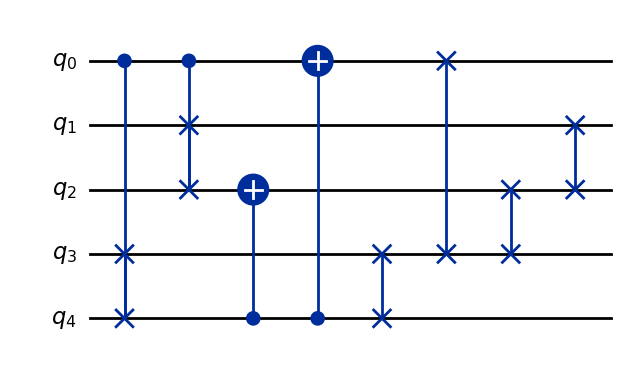

In [69]:
puerta_exp_mod = exp_mod21(1).decompose()
display(puerta_exp_mod.draw("mpl"))

Si realizamos un traspilado al _backend_ que emplearemos para la simulación ($\verb|qasm_simulator|$), observamos que no es necesario descomponer el circuito en puertas más elementales para su implementación.

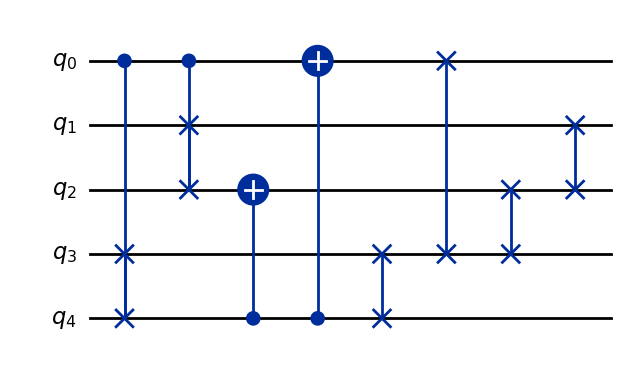

In [70]:
backend = Aer.get_backend("qasm_simulator")
puerta_exp_mod_t = transpile(puerta_exp_mod,backend)
display(puerta_exp_mod_t.draw("mpl"))

Podemos entonces analizar la profundidad y el número de puertas con el siguiente código:

In [71]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in puerta_exp_mod_t.count_ops().items():
    print(f"{k:<18} {v}")
print("\nEl circuito tiene una profundidad de", puerta_exp_mod_t.depth())

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
swap               4
cswap              2
cx                 2

El circuito tiene una profundidad de 8


Apliquemos esta puerta para el circuito que nos ocupa. En primer lugar, debemos inicializar las variables $N$ y $x$ de acuerdo al contexto en el que estamos.

In [72]:
# Inicializamos N y x
N = 21
x = 2

A continuación se crea el circuito correspondiente a la parte cuántica del algoritmo de Shor:

Tiempo de creación del circuito: 8.882041215896606 segundos.


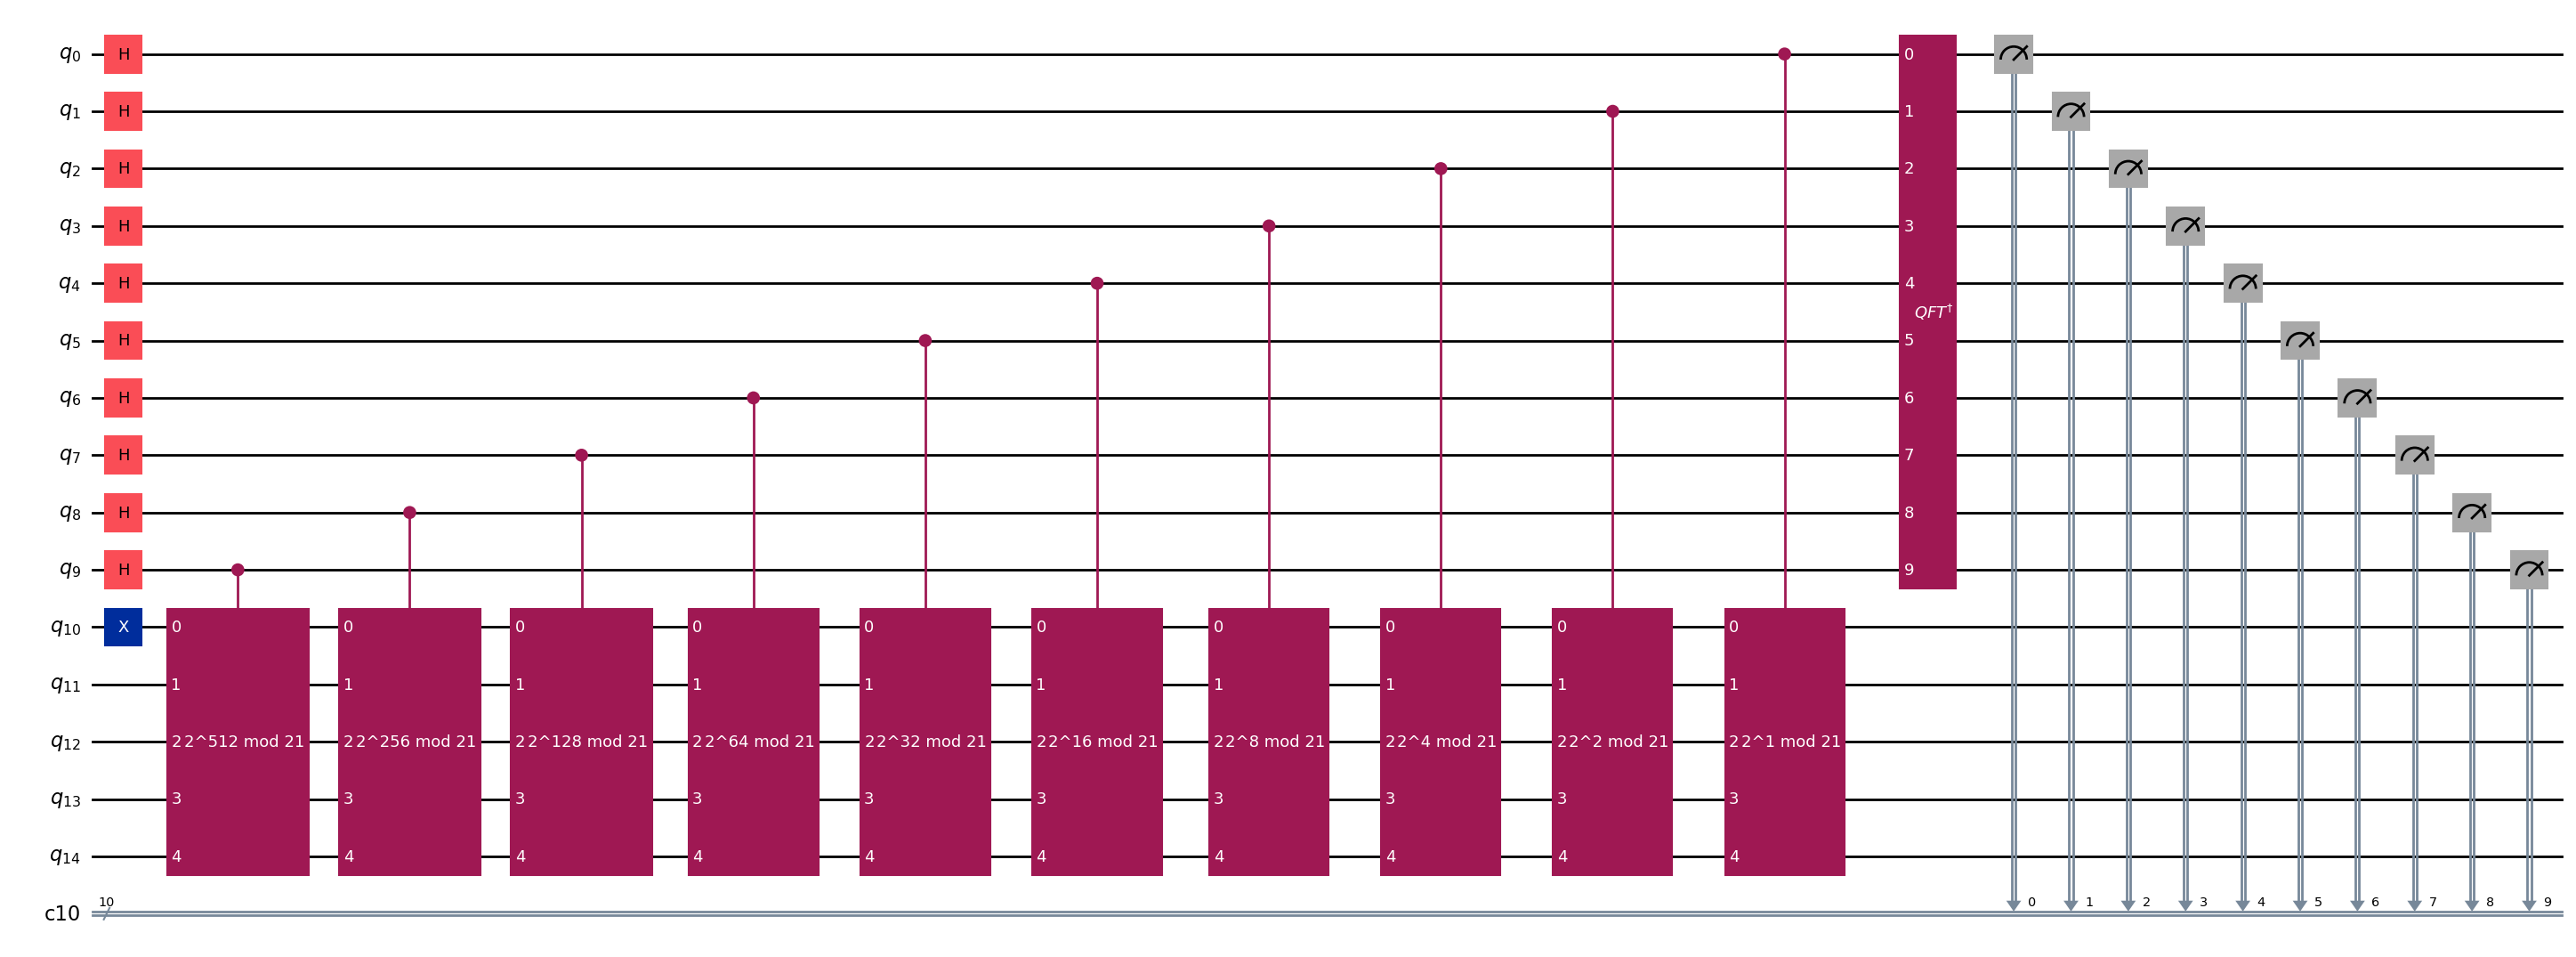

In [73]:
# Parte cuántica del algoritmo de Shor. Implementación en Qiskit 1.0.2
t0 = time.time() # Inicio de la construcción del circuito
# Calculamos los qubits necesarios
n_in_qubits = int(np.ceil(np.log2(N)))
n_out_qubits = 2*n_in_qubits
n_qubits = n_out_qubits + n_in_qubits

# Circuito de Shor
shor_qreg = QuantumRegister(n_qubits, name='q')
shor_creg = ClassicalRegister(n_out_qubits)

shor_circ = QuantumCircuit(shor_qreg,shor_creg,name="Shor")

# Puertas hadamard a los 'n_in_qubits' qubits del registro de estimación
shor_circ.h(range(n_out_qubits))

# Puerta X al qubit menos significativo del registro del autovector
shor_circ.x(n_out_qubits)

# Puertas de exponeciación modular controladas
for i in range(n_out_qubits):
    shor_circ.append(exp_mod21(2**(n_out_qubits - 1 - i)).control(1),[n_out_qubits - 1 - i] + [j for j in list(range(n_out_qubits,n_qubits)) ])

# Transformada de Fourier cuántica inversa
shor_circ.append(QFT(n_out_qubits,inverse=True, name='$QFT^{\dagger}$'),[j for j in range(n_out_qubits)])

# Medidas
shor_circ.measure([shor_qreg[i] for i in range(n_out_qubits-1,-1,-1)],[shor_creg[ n_out_qubits - 1 - i] for i in range(n_out_qubits)])

# Tiempo de creación
print("Tiempo de creación del circuito:",time.time()-t0,"segundos.")

# Mostramos el circuito descomponiendo únicamente las puertas controladas por comodidad visual
display(shor_circ.decompose(gates_to_decompose=['c_2^' + str(power) + ' mod 21' for power in [2**i for i in range(n_out_qubits)]]).draw("mpl",fold=-1))

Para revisar que el circuito es adecuado, ejecutémoslo (realizaremos 10000 _shots_), y filtremos los resultados.

Tiempo de transpilado a simulador: 7.698544502258301 segundos.
Tiempo de ejecución en simulador: 6.271967887878418 segundos.


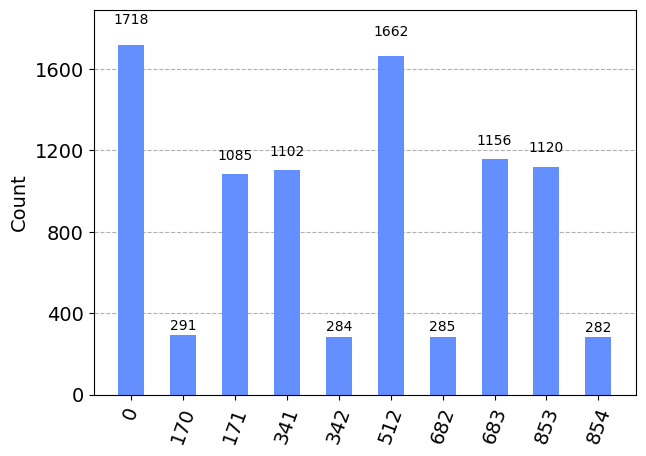

In [74]:
# Ejecución en simulador
backend = Aer.get_backend("qasm_simulator")
t0 = time.time() # Tiempo de inicio. Obviamos el obtener un backend
shor_circ_t = transpile(shor_circ,backend)
t_transpile = time.time() # Fin de transpilado
result = backend.run(shor_circ_t,shots = 10000).result()
t_result = time.time() # Fin de ejecución

print("Tiempo de transpilado a simulador:",t_transpile - t0,"segundos.")
print("Tiempo de ejecución en simulador:",t_result-t_transpile,"segundos.")

# Filtramos los resultados a aquellos superando el 1 por ciento de los shots realizados
counts_dec = {int(v,2):k for v,k in result.get_counts().items() if k > 0.01*10000}

# Histograma filtrado
display(plot_histogram(counts_dec))

En efecto, si hacemos uso de la teoría de las fracciones continuas podemos deducir el orden multiplicativo. En el siguiente código se muestra cómo.

In [75]:
# Calculamos todos los posibles periodos
for i in sorted(counts_dec):
    convergente = Fraction(i,2**n_out_qubits).limit_denominator(N)
    print("La medida es " + str(i) + " la convergente es " + str(convergente) + ". Periodo " + str(convergente.denominator))

La medida es 0 la convergente es 0. Periodo 1
La medida es 170 la convergente es 1/6. Periodo 6
La medida es 171 la convergente es 1/6. Periodo 6
La medida es 341 la convergente es 1/3. Periodo 3
La medida es 342 la convergente es 1/3. Periodo 3
La medida es 512 la convergente es 1/2. Periodo 2
La medida es 682 la convergente es 2/3. Periodo 3
La medida es 683 la convergente es 2/3. Periodo 3
La medida es 853 la convergente es 5/6. Periodo 6
La medida es 854 la convergente es 5/6. Periodo 6


El orden es 6, tal y como esperábamos. Aprovechando que hemos traspilado el circuito anterior, analicemos este.

In [76]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in shor_circ_t.count_ops().items():
    print(f"{k:<18} {v}")
print("\nEl circuito tiene una profundidad de", shor_circ_t.depth())

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
ccx                30690
u                  28644
cx                 28644
cu                 4092
cp                 45
h                  20
measure            10
swap               5
p                  3
x                  1



El circuito tiene una profundidad de 85955


La cantidad de puertas y la profundidad del circuito son considerables. En el caso de aumentar en uno los qubits de precisión, las puertas que constituyen la exponenciación modular adicional prácticamente duplicarían al número de las ya existentes. Si bien no es preciso aumentar la precisión, para factorizar enteros cuya representación binaria exceda los 5 _qubits_ (suponiendo que conocemos el circuito de la exponenciación modular), el rendimiento del circuito se verá gravemente afectado con los medios actuales.

Concluiremos este análisis observando lo que ocurre cuando aumentamos la precisión de la estimación de fase considerando dos _qubits_ de conteo más. Esto podría darnos una idea (bastante aproximada), del tiempo necesario para factorizar enteros de más de 5 bits. Esto último no podemos hacerlo dado que sería necesario una puerta de exponenciación modular diferente a la anterior.

In [77]:
# Parte cuántica del algoritmo de Shor. Implementación en Qiskit 1.0.2
t0 = time.time() # Inicio de la construcción del circuito
# Calculamos los qubits necesarios
n_in_qubits = int(np.ceil(np.log2(N)))
n_out_qubits = 2*n_in_qubits + 2 # Aumentamos en 2 la precisión
n_qubits = n_out_qubits + n_in_qubits

# Circuito de Shor
shor_qreg = QuantumRegister(n_qubits, name='q')
shor_creg = ClassicalRegister(n_out_qubits)

shor_circ = QuantumCircuit(shor_qreg,shor_creg,name="Shor")

# Puertas hadamard a los 'n_in_qubits' qubits del registro de estimación
shor_circ.h(range(n_out_qubits))

# Puerta X al qubit menos significativo del registro del autovector
shor_circ.x(n_out_qubits)

# Puertas de exponeciación modular controladas
for i in range(n_out_qubits):
    shor_circ.append(exp_mod21(2**(n_out_qubits - 1 - i)).control(1),[n_out_qubits - 1 - i] + [j for j in list(range(n_out_qubits,n_qubits)) ])

# Transformada de Fourier cuántica inversa
shor_circ.append(QFT(n_out_qubits,inverse=True, name='$QFT^{\dagger}$'),[j for j in range(n_out_qubits)])

# Medidas
shor_circ.measure([shor_qreg[i] for i in range(n_out_qubits-1,-1,-1)],[shor_creg[ n_out_qubits - 1 - i] for i in range(n_out_qubits)])

# Tiempo de creación
print("Tiempo de creación del circuito:",time.time()-t0,"segundos.")

# Para mostrar el circuito como antes descomentar la línea de código siguiente
# display(shor_circ.decompose(gates_to_decompose=['c_2^' + str(power) + ' mod 21' for power in [2**i for i in range(n_out_qubits)]]).draw("mpl",fold=-1))

Tiempo de creación del circuito: 33.919554471969604 segundos.


Tiempo de transpilado a simulador: 28.565704584121704 segundos.
Tiempo de ejecución en simulador: 80.25805234909058 segundos.


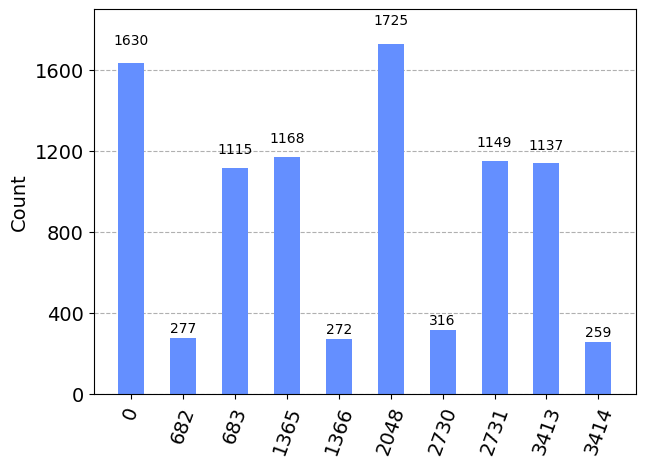

In [78]:
# Ejecución en simulador
backend = Aer.get_backend("qasm_simulator")
t0 = time.time() # Tiempo de inicio. Obviamos el obtener un backend
shor_circ_t = transpile(shor_circ,backend)
t_transpile = time.time() # Fin de transpilado
result = backend.run(shor_circ_t,shots = 10000).result()
t_result = time.time() # Fin de ejecución

print("Tiempo de transpilado a simulador:",t_transpile - t0,"segundos.")
print("Tiempo de ejecución en simulador:",t_result-t_transpile,"segundos.")

# Filtramos los resultados a aquellos superando el 1 por ciento de los shots realizados
counts_dec = {int(v,2):k for v,k in result.get_counts().items() if k > 0.01*10000}

# Histograma filtrado
display(plot_histogram(counts_dec))

Como podemos observar, los tiempos de creación, transpilado y ejecución del circuito se ven incrementados sustancialmente. Los resultados siguen ofreciéndonos el orden multiplicativo que buscamos. Recordemos que estos deben adaptarse al aumento de la precisión.

In [79]:
# Calculamos todos los posibles periodos
for i in sorted(counts_dec):
    convergente = Fraction(i,2**n_out_qubits).limit_denominator(N)
    print("La medida es " + str(i) + " la convergente es " + str(convergente) + ". Periodo " + str(convergente.denominator))

La medida es 0 la convergente es 0. Periodo 1
La medida es 682 la convergente es 1/6. Periodo 6
La medida es 683 la convergente es 1/6. Periodo 6
La medida es 1365 la convergente es 1/3. Periodo 3
La medida es 1366 la convergente es 1/3. Periodo 3
La medida es 2048 la convergente es 1/2. Periodo 2
La medida es 2730 la convergente es 2/3. Periodo 3
La medida es 2731 la convergente es 2/3. Periodo 3
La medida es 3413 la convergente es 5/6. Periodo 6
La medida es 3414 la convergente es 5/6. Periodo 6


Finalmente, el número de puertas y la profundidad que presenta el nuevo circuito se muestra a continuación.

In [80]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in shor_circ_t.count_ops().items():
    print(f"{k:<18} {v}")
print("\nEl circuito tiene una profundidad de", shor_circ_t.depth())

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número


ccx                122850
u                  114660
cx                 114660
cu                 16380
cp                 66
h                  24
measure            12
swap               6
p                  4
x                  1

El circuito tiene una profundidad de 344007
